In [3]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import lombscargle, savgol_filter
import pylab

In [4]:
# RV UMa: 1561928427003019520
# RZ Cep: 2211629018927324288
query = f"""
        SELECT *
        FROM gaiadr3.gaia_source
        WHERE has_epoch_photometry = 'True'
        AND source_id IN (1561928427003019520, 2211629018927324288)
        """
job = Gaia.launch_job_async(query)
results = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [14]:
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'
datalink = Gaia.load_data(ids=results['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False)
dl_keys = [inp for inp in datalink.keys()] # Getting Epoch photometry keys for RV UMa & RZ Cep
dl_keys.sort()
RV_UMa_dl_key = dl_keys[0]
RZ_Cep_dl_key = dl_keys[1]
# Creating a readable table
RV_UMa_votable_data = datalink[RV_UMa_dl_key][0].to_table()
RZ_Cep_votable_data = datalink[RZ_Cep_dl_key][0].to_table()
type(RZ_Cep_votable_data)

astropy.table.table.Table

In [16]:
# Gets observation times and magnitudes for each band for each star
def get_times_and_mags(time, flux, flux_err, votable_data):
    band_time  = np.array(votable_data[time])
    band_flux = np.array(votable_data[flux])
    band_flux_err = np.array(votable_data[flux_err])
    return (band_time, band_flux, band_flux_err)

In [17]:
RV_UMa_g_time, RV_UMa_g_flux, RV_UMa_g_flux_err = get_times_and_mags('g_transit_time', 'g_transit_flux', 'g_transit_flux_error', RV_UMa_votable_data)
RV_UMa_bp_time, RV_UMa_bp_flux, RV_UMa_bp_flux_err = get_times_and_mags('bp_obs_time', 'bp_flux', 'bp_flux_error', RV_UMa_votable_data)
RV_UMa_rp_time, RV_UMa_rp_flux, RV_UMa_rp_flux_err = get_times_and_mags('rp_obs_time', 'rp_flux', 'rp_flux_error', RV_UMa_votable_data)

array([1667.2528635 , 1667.50301735, 1667.5770218 , 1667.75317145,
       1667.82718999, 1668.00332579, 1668.0773445 , 1668.25348037,
       1668.32748534, 1668.57765427, 1700.60121952, 1700.77737643,
       1724.03384374, 1724.10785184, 1746.23820525, 1746.4143555 ,
       1773.16401518, 1773.23803887, 1804.72504316, 1840.11943148,
       1840.19344053, 1858.19434927, 1858.3705158 , 1899.81180101,
       1899.88579885, 2013.23974132, 2013.3137442 , 2054.47212934,
       2054.54615091, 2054.72230482, 2078.47798492, 2078.55200603,
       2123.78712726, 2123.9633083 , 2152.53191357, 2180.94767056,
       2181.02168398, 2217.9092886 , 2217.98328357, 2233.98580372,
       2276.10139397, 2276.1753994 , 2291.3543204 , 2331.30897378,
       2359.04910404, 2359.12310971, 2390.78744388, 2390.86144734,
       2435.2706236 ,           nan,           nan, 2458.52717984,
       2458.60118725, 2458.77735888, 2458.8513539 , 2501.01186697,
       2501.08587996,           nan, 2531.57468163, 2556.99346

In [6]:
RZ_Cep_g_time, RZ_Cep_g_flux, RZ_Cep_g_flux_err = get_times_and_mags('g_transit_time', 'g_transit_flux', 'g_transit_flux_error', RZ_Cep_votable_data)
RZ_Cep_bp_time, RZ_Cep_bp_flux, RZ_Cep_bp_flux_err = get_times_and_mags('bp_obs_time', 'bp_flux', 'bp_flux_error', RZ_Cep_votable_data)
RZ_Cep_rp_time, RZ_Cep_rp_flux, RZ_Cep_rp_flux_err = get_times_and_mags('rp_obs_time', 'rp_flux', 'bp_flux_error', RZ_Cep_votable_data)

In [7]:
interp_savgol = savgol_filter(RZ_Cep_g_flux, window_length=46, polyorder=3)

In [8]:
time_start = RZ_Cep_g_time[1] - RZ_Cep_g_time[0]
time_finish = RZ_Cep_g_time[-1] - RZ_Cep_g_time[0]

In [9]:
freqs = np.linspace((1 / time_finish), (1 / time_start), 20000)
lomb = scipy.signal.lombscargle(RZ_Cep_g_time, RZ_Cep_g_flux / interp_savgol, freqs, precenter=True)

In [10]:
#period = np.linspace(0.1, 1, 20000)
#lomb2 = scipy.signal.lombscargle(freqs, lomb, period, precenter=True)

In [11]:
#new_period = period[2000:]
#new_period
#new_lomb2 = lomb2[2000:]

In [12]:
#fig1_text = """Figure 1: A periodogram showing the periods of the exoplanets. The spikes represent the periods of all the exoplanets in the system.
#Some values, however, are multiples of exisiting exoplanets and therefore these values need to be identified and discarded."""

#fig1 = plt.figure()
#ax1 = fig1.add_axes((.1,.4,.8,.5))
#ax1.plot(freqs, lomb, color='Black')
#ax1.set_xlabel("Period (Days)")
#ax1.set_ylabel("Power")
#fig1.text(.1,.2,fig1_text)
#plt.show()

In [13]:
def fold_lightcurve(time, mag, error, period):
    """
    Folds the lightcurve given a period.
    time: input time (same unit as period)
    mag: input magnitude
    error: input error
    period: period to be folded to, needs to same unit as time (i.e. days)
    returns: phase, folded magnitude, folded error
    """
    # Create a pandats dataframe from
    data = pd.DataFrame({"time": time, "flux": mag, "error": error})

    # create the phase
    data["phase"] = data.apply(lambda x: ((x.time / period) - np.floor(x.time / period)), axis=1)

    # Creates the out phase, flux and error
    phase_long = np.concatenate((data["phase"], data["phase"] + 1.0))
    mag_long = np.concatenate((mag, mag))
    err_long = np.concatenate((error, error))

    phase_sort = np.argsort(phase_long)
    phase_long_sorted = phase_long[phase_sort]
    mag_long_sorted = mag_long[phase_sort]
    err_long_sorted = err_long[phase_sort]

    nanmask = ~np.isnan(phase_long_sorted) & ~np.isnan(mag_long_sorted) & ~np.isnan(err_long_sorted)
    
    return (phase_long_sorted[nanmask], mag_long_sorted[nanmask], err_long_sorted[nanmask])

In [14]:
RV_UMa_period = 0.46805905525592434 # From GAIA DR3
RV_UMa_g_phase, RV_UMa_g_phase_flux, RV_UMa_g_phase_err = fold_lightcurve(RV_UMa_g_time, RV_UMa_g_flux, RV_UMa_g_flux_err, RV_UMa_period)
RV_UMa_bp_phase, RV_UMa_bp_phase_flux, RV_UMa_bp_phase_err = fold_lightcurve(RV_UMa_bp_time, RV_UMa_bp_flux, RV_UMa_bp_flux_err, RV_UMa_period)
RV_UMa_rp_phase, RV_UMa_rp_phase_flux, RV_UMa_rp_phase_err = fold_lightcurve(RV_UMa_rp_time, RV_UMa_rp_flux, RV_UMa_rp_flux_err, RV_UMa_period)

In [15]:
RZ_Cep_period = 0.308704 # From SIMBAD
RZ_Cep_g_phase, RZ_Cep_g_phase_flux, RZ_Cep_g_phase_err = fold_lightcurve(RZ_Cep_g_time, RZ_Cep_g_flux, RZ_Cep_g_flux_err, RZ_Cep_period)
RZ_Cep_bp_phase, RZ_Cep_bp_phase_flux, RZ_Cep_bp_phase_err = fold_lightcurve(RZ_Cep_bp_time, RZ_Cep_bp_flux, RZ_Cep_bp_flux_err, RZ_Cep_period)
RZ_Cep_rp_phase, RZ_Cep_rp_phase_flux, RZ_Cep_rp_phase_err = fold_lightcurve(RZ_Cep_rp_time, RZ_Cep_rp_flux, RZ_Cep_rp_flux_err, RZ_Cep_period)

In [16]:
zeropoint_arr = np.loadtxt('GaiaEDR3_passbands_zeropoints_version2/zeropt.dat', dtype='str')
G_band_zp = float(zeropoint_arr[0][0])
G_band_zp_unc = float(zeropoint_arr[0][1])
BP_band_zp = float(zeropoint_arr[0][2])
BP_band_zp_unc = float(zeropoint_arr[0][3])
RP_band_zp = float(zeropoint_arr[0][4])
RP_band_zp_unc = float(zeropoint_arr[0][5])


In [17]:
def flux_to_mag(flux_array, zeropoint):
    mag_array = -2.5 * np.log10(flux_array) + zeropoint
    return mag_array

In [18]:
def mag_error(flux_array, flux_err_array, zeropoint, zeropoint_err):
    mag_err_array = []
    dM_dF = - 5 / (2 * np.log(10) * flux_array)
    dM_dZ = 1
    mag_err = np.sqrt(np.square(dM_dF * flux_err_array) + np.square(dM_dZ * zeropoint_err))
    return mag_err

In [19]:
RV_UMa_g_phase_mag = flux_to_mag(RV_UMa_g_phase_flux, G_band_zp)
RV_UMa_bp_phase_mag = flux_to_mag(RV_UMa_bp_phase_flux, BP_band_zp)
RV_UMa_rp_phase_mag = flux_to_mag(RV_UMa_rp_phase_flux, RP_band_zp)

In [20]:
RV_UMa_g_phase_mag_err = mag_error(RV_UMa_g_phase_flux, RV_UMa_g_phase_err, G_band_zp, G_band_zp_unc)
RV_UMa_bp_phase_mag_err = mag_error(RV_UMa_bp_phase_flux, RV_UMa_bp_phase_err, BP_band_zp, BP_band_zp_unc)
RV_UMa_rp_phase_mag_err = mag_error(RV_UMa_rp_phase_flux, RV_UMa_rp_phase_err, RP_band_zp, RP_band_zp_unc)

In [63]:
RZ_Cep_g_phase_mag = flux_to_mag(RZ_Cep_g_phase_flux, G_band_zp)
RZ_Cep_bp_phase_mag = flux_to_mag(RZ_Cep_bp_phase_flux, BP_band_zp)
RZ_Cep_rp_phase_mag = flux_to_mag(RZ_Cep_rp_phase_flux, RP_band_zp)
1.0857*(RZ_Cep_g_phase_err/RZ_Cep_g_phase_flux)

array([0.00194777, 0.00069324, 0.00040536, 0.00061589, 0.00068695,
       0.0006085 , 0.00080445, 0.00068796, 0.00061259, 0.00126501,
       0.00091376, 0.00189918, 0.00203348, 0.00093516, 0.00060064,
       0.00069884, 0.00097489, 0.00050275, 0.000664  , 0.00040701,
       0.00069733, 0.00251156, 0.00166236, 0.00159171, 0.00678527,
       0.00152698, 0.0016425 , 0.000832  , 0.00156481, 0.00092947,
       0.00104339, 0.00179137, 0.00092225, 0.0005914 , 0.00217607,
       0.00114049, 0.0006729 , 0.00090938, 0.00680833, 0.00124873,
       0.00072631, 0.00067448, 0.00070405, 0.00147744, 0.00077753,
       0.00087325, 0.00194777, 0.00069324, 0.00040536, 0.00061589,
       0.00068695, 0.0006085 , 0.00080445, 0.00068796, 0.00061259,
       0.00126501, 0.00091376, 0.00189918, 0.00203348, 0.00093516,
       0.00060064, 0.00069884, 0.00097489, 0.00050275, 0.000664  ,
       0.00040701, 0.00069733, 0.00251156, 0.00166236, 0.00159171,
       0.00678527, 0.00152698, 0.0016425 , 0.000832  , 0.00156

In [67]:
RZ_Cep_g_phase_mag_err = mag_error(RZ_Cep_g_phase_flux, RZ_Cep_g_phase_err, G_band_zp, G_band_zp_unc)
RZ_Cep_bp_phase_mag_err = mag_error(RZ_Cep_bp_phase_flux, RZ_Cep_bp_phase_err, BP_band_zp, BP_band_zp_unc)
RZ_Cep_rp_phase_mag_err = mag_error(RZ_Cep_rp_phase_flux, RZ_Cep_rp_phase_err, RP_band_zp, RP_band_zp_unc)
RZ_Cep_g_phase_mag_err

array([0.00337429, 0.0028412 , 0.00278498, 0.00282332, 0.00283967,
       0.00282172, 0.00287036, 0.00283991, 0.0028226 , 0.00303186,
       0.00290289, 0.00334648, 0.00342449, 0.0029097 , 0.00282003,
       0.00284257, 0.00292272, 0.00280082, 0.0028342 , 0.00278522,
       0.0028422 , 0.00372829, 0.00321798, 0.00318206, 0.00732358,
       0.00315018, 0.00320777, 0.0028782 , 0.00316869, 0.00290788,
       0.00294627, 0.00328649, 0.00290558, 0.00281808, 0.00351104,
       0.00298204, 0.0028363 , 0.00290152, 0.00734495, 0.0030251 ,
       0.00284945, 0.00283668, 0.00284385, 0.00312646, 0.00286293,
       0.0028904 , 0.00337429, 0.0028412 , 0.00278498, 0.00282332,
       0.00283967, 0.00282172, 0.00287036, 0.00283991, 0.0028226 ,
       0.00303186, 0.00290289, 0.00334648, 0.00342449, 0.0029097 ,
       0.00282003, 0.00284257, 0.00292272, 0.00280082, 0.0028342 ,
       0.00278522, 0.0028422 , 0.00372829, 0.00321798, 0.00318206,
       0.00732358, 0.00315018, 0.00320777, 0.0028782 , 0.00316

In [23]:
def sine_function(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

In [24]:
def sin_fit(phase, phase_mag, initial_guess):
    popt, pcov = curve_fit(sine_function, phase, phase_mag, p0=initial_guess)
    A_fit, B_fit, C_fit, D_fit = popt
    print(f"Fitted parameters: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit}")
    y_fit = sine_function(phase, A_fit, B_fit, C_fit, D_fit)
    return y_fit


In [25]:
z = np.polyfit(RV_UMa_g_phase, RV_UMa_g_phase_mag, 18)
f = np.poly1d(z)

x_new = np.linspace(RV_UMa_g_phase[0], RV_UMa_g_phase[-1], 100)
y_new = f(x_new)



In [26]:
for i in range(len(x_new)-1):
    (np.absolute(y_new[i+1]-y_new[i] / x_new[i+1]-x_new[i]))

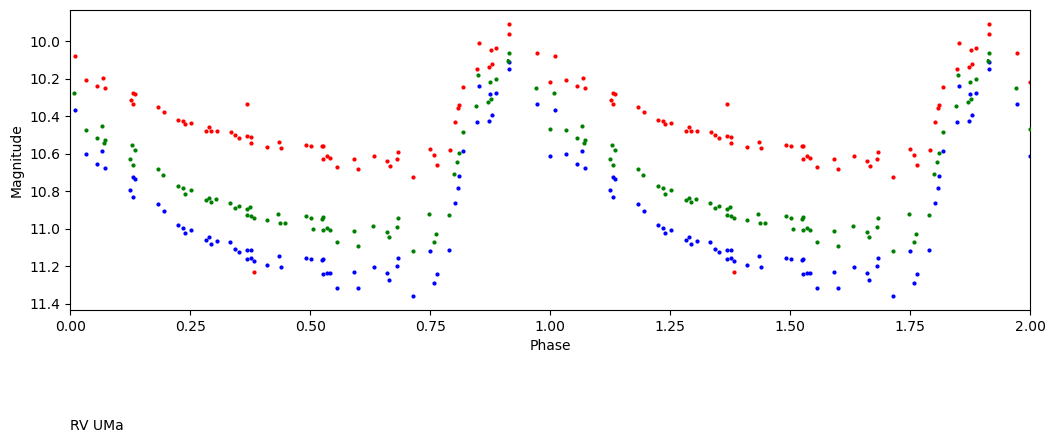

In [46]:
fig2_text = "RV UMa"

fig2 = plt.figure(figsize=(12,6))
ax2 = fig2.add_axes((.1,.4,.8,.5))
ax2.errorbar(RV_UMa_g_phase, RV_UMa_g_phase_mag, yerr=RV_UMa_g_phase_mag_err, marker='o', ms=2, ls='None', zorder=3, c='Green')
ax2.errorbar(RV_UMa_bp_phase, RV_UMa_bp_phase_mag, yerr=RV_UMa_bp_phase_mag_err, marker='o', ms=2, ls='None', zorder=2, c='Blue')
ax2.errorbar(RV_UMa_rp_phase, RV_UMa_rp_phase_mag, yerr=RV_UMa_rp_phase_mag_err, marker='o', ms=2, ls='None', zorder=1, c='Red')
#plt.plot(x_new, y_new, color='Black')

ax2.set_xlabel("Phase")
ax2.set_ylabel("Magnitude")
ax2.yaxis.set_inverted(True)
fig2.text(.1,.2,fig2_text)
plt.xlim([0,2])
plt.show()

In [28]:
#phase_sort = np.argsort(RZ_Cep_g_phase)
#RZ_Cep_g_phase_sorted = RZ_Cep_g_phase[phase_sort]
#RZ_Cep_g_phase_mag_sorted = RZ_Cep_g_phase_mag[phase_sort]
#RZ_Cep_g_phase_mag_err_sorted = RZ_Cep_g_phase_mag_err[phase_sort]

In [29]:
initial_guess_RZ_Cep = [0.2, 2*np.pi, 3.3, 9.2]

y_fit_g = sin_fit(RZ_Cep_g_phase, RZ_Cep_g_phase_mag, initial_guess_RZ_Cep)
y_fit_bp = sin_fit(RZ_Cep_bp_phase, RZ_Cep_bp_phase_mag, initial_guess_RZ_Cep)
y_fit_rp = sin_fit(RZ_Cep_rp_phase, RZ_Cep_rp_phase_mag, initial_guess_RZ_Cep)

Fitted parameters: A=-0.2408563055678568, B=6.387928455781455, C=2.475352155773691, D=9.280862897026658
Fitted parameters: A=-0.29790283955046615, B=6.3911947909903875, C=2.5238391674402223, D=9.570013113386265
Fitted parameters: A=-0.18352905376219816, B=6.408558093908568, C=2.459774934035929, D=8.811458041113017


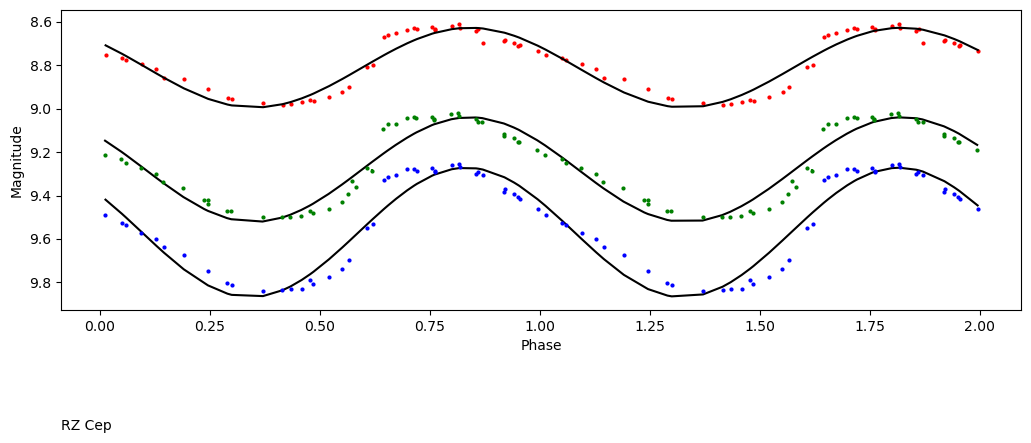

In [47]:


fig3_text = "RZ Cep"

fig3 = plt.figure(figsize=(12,6))
ax3 = fig3.add_axes((.1,.4,.8,.5))
ax3.errorbar(RZ_Cep_g_phase, RZ_Cep_g_phase_mag, yerr=RZ_Cep_g_phase_mag_err, marker='o', ms=2, ls='None', zorder=3, c='Green')
ax3.errorbar(RZ_Cep_bp_phase, RZ_Cep_bp_phase_mag, yerr=RZ_Cep_bp_phase_mag_err, marker='o', ms=2, ls='None', zorder=2, c='Blue')
ax3.errorbar(RZ_Cep_rp_phase, RZ_Cep_rp_phase_mag, yerr=RZ_Cep_rp_phase_mag_err, marker='o', ms=2, ls='None', zorder=1, c='Red')
plt.plot(RZ_Cep_g_phase, y_fit_g, label='Fitted Curve', color='black')
plt.plot(RZ_Cep_bp_phase, y_fit_bp, label='Fitted Curve', color='black')
plt.plot(RZ_Cep_rp_phase, y_fit_rp, label='Fitted Curve', color='black')

ax3.set_xlabel("Phase")
ax3.set_ylabel("Magnitude")
ax3.yaxis.set_inverted(True)
fig3.text(.1,.2,fig3_text)
plt.show()